In [1]:
%pylab inline
import emcee
import programas as pg
import h5py
import MAS_library as MASL
import smoothing_library as SL

Populating the interactive namespace from numpy and matplotlib


In [12]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F0, F1, F2, F3,F4, C_inv, P_obs, P00, P01, P02, P03, P04,
                                    P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, ndens, C_inv_pk):
    
    b1, b2, b3,b4, A = params
    model_perfil = F0 + b1 * F1 + b2 * F2 + b3 * F3 + b4*F4 - 1
    diff_perfil = F_obs - model_perfil
    
    b0 = 1
    model_pk = (b0*b0*P00 + b0*b1*P01 + b0*b2*P02 + b0*b3*P03 + b0*b4*P04+
           b1*b0*P01 + b1*b1*P11 + b1*b2*P12 + b1*b3*P13 + b1*b4*P14 +
           b2*b0*P02 + b2*b1*P12 + b2*b2*P22 + b2*b3*P23 + b2*b4*P24 +
           b3*b0*P03 + b3*b1*P13 + b3*b2*P23 + b3*b3*P33 + b3*b4*P34 +
           b4*b0*P04 + b4*b1*P14 + b4*b2*P24 + b4*b3*P34 + b4*b4*P44) + A/ndens
    
    diff_pk = P_obs - model_pk

    return -0.5 * np.dot(diff_perfil, np.dot(C_inv, diff_perfil)) -0.5 * np.dot(diff_pk, np.dot(C_inv_pk, diff_pk))

# Priors
def log_prior(params):
    b1, b2, b3, b4, A = params
    if -20 < b1 < 20 and -20 < b2 < 20 and -20 < b3 < 20 and -50 < b4 < 50 and 0 < A < 2:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F0, F1, F2,F3, F4, C_inv, P_obs, P00, P01, P02, P03, P04,
                                    P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, ndens, C_inv_pk):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F0, F1, F2, F3,F4, C_inv, P_obs, P00, P01, P02, P03, P04,
                                    P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, ndens, C_inv_pk)



def covariance_mat(pmean, pall):
    
    njack  = pall.shape[0]
    nbines = pall.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

In [3]:
# Función de verosimilitud conjunta
def log_likelihood2(params, F_obs, F0, F1, F2, F3, F4, C_inv, Pk_obs, pk_model, k_values, errors_Pk):
    """
    Calcula la log-likelihood conjunta para el perfil y el espectro de potencias.

    Parámetros:
    -----------
    params: array
        Parámetros del modelo [b1, b2, b3, b4, A].
    F_obs: array
        Datos observados del perfil.
    F0, F1, F2, F3, F4: arrays
        Componentes del modelo del perfil.
    C_inv: 2D array
        Matriz inversa de covarianza para los datos del perfil.
    Pk_obs: array
        Datos observados del espectro de potencias.
    pk_model: función
        Función que calcula el modelo de P(k) dado los parámetros y las frecuencias k.
    k_values: array
        Valores de \( k \) correspondientes a los datos de \( P(k) \).
    errors_Pk: array
        Errores en los datos de \( P(k) \) (diagonal de la matriz de covarianza).

    Retorna:
    --------
    float
        La log-verosimilitud conjunta.
    """
    # Parámetros del modelo
    b1, b2, b3, b4, A = params

    # Likelihood para el perfil
    model_perfiles = F0 + b1 * F1 + b2 * F2 + b3 * F3 + b4 * F4 - 1
    diff_perfiles = F_obs - model_perfiles
    logL_perfiles = -0.5 * np.dot(diff_perfiles, np.dot(C_inv, diff_perfiles))

    # Likelihood para el espectro de potencias
    model_Pk = pk_model(b1, b2, b3, b4, A, k_values)
    diff_Pk = Pk_obs - model_Pk
    logL_Pk = -0.5 * np.sum((diff_Pk / errors_Pk) ** 2)

    # Log-likelihood conjunta
    logL_total = logL_perfiles + logL_Pk
    return logL_total

In [4]:
def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [59]:
rmin = 16
smooth = 12
damping_scale = 0.75

path = '/home/arodriguez/BACCO/bias-voids/IATE/perfiles/4f/'
f0_file = np.load(path+'perfiles_F0_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f1_file = np.load(path+'perfiles_F1_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f2_file = np.load(path+'perfiles_F2_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f3_file = np.load(path+'perfiles_F3_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f4_file = np.load(path+'perfiles_F4_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')

f0 = f0_file[:,1:]
f1 = f1_file[:,1:]
f2 = f2_file[:,1:]
f3 = f3_file[:,1:]
f4 = f4_file[:,1:]

realizaciones = 80

mean_0, error_0 = pg.perfil_jack(f0,realizaciones)
mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
mean_3, error_3 = pg.perfil_jack(f3,realizaciones)
mean_4, error_4 = pg.perfil_jack(f4,realizaciones)

original = np.load(path+'perfiles_simulation_smooth_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
obs = original[:,1:]
mean_obs, error_obs = pg.perfil_jack(obs,realizaciones)

R_sm = smooth

path = '/home/arodriguez/BACCO/bias-voids/IATE/PowerSpectrum/'
k_full   = np.load(path+'k_'+str(R_sm)+'.npy')
P00_full = np.load(path+'P00_'+str(R_sm)+'.npy')
P01_full = np.load(path+'P01_'+str(R_sm)+'.npy')
P02_full = np.load(path+'P02_'+str(R_sm)+'.npy')
P03_full = np.load(path+'P03_'+str(R_sm)+'.npy')
P04_full = np.load(path+'P04_'+str(R_sm)+'.npy')
P11_full = np.load(path+'P11_'+str(R_sm)+'.npy')
P12_full = np.load(path+'P12_'+str(R_sm)+'.npy')
P13_full = np.load(path+'P13_'+str(R_sm)+'.npy')
P14_full = np.load(path+'P14_'+str(R_sm)+'.npy')
P22_full = np.load(path+'P22_'+str(R_sm)+'.npy')
P23_full = np.load(path+'P23_'+str(R_sm)+'.npy')
P24_full = np.load(path+'P24_'+str(R_sm)+'.npy')
P33_full = np.load(path+'P33_'+str(R_sm)+'.npy')
P34_full = np.load(path+'P34_'+str(R_sm)+'.npy')
P44_full = np.load(path+'P44_'+str(R_sm)+'.npy')

P_obs_full = np.load(path+'Psimu_'+str(R_sm)+'.npy')


sel, = np.where( k_full < 0.7 )
npower = len(sel)
print('dim:',npower)

P00 = P00_full[sel]
P01 = P01_full[sel]
P02 = P02_full[sel]
P03 = P03_full[sel]
P04 = P04_full[sel]
P11 = P11_full[sel]
P12 = P12_full[sel]
P13 = P13_full[sel]
P14 = P14_full[sel]
P22 = P22_full[sel]
P23 = P23_full[sel]
P24 = P24_full[sel]
P33 = P33_full[sel]
P34 = P34_full[sel]
P44 = P44_full[sel]
P_obs = P_obs_full[sel]
k = k_full[sel]

FileNotFoundError: [Errno 2] No such file or directory: '/home/arodriguez/BACCO/bias-voids/IATE/PowerSpectrum/k_12.npy'

In [60]:
mean_obs, error_obs, all_obs = perfil_jack(obs,realizaciones)

In [61]:
C = covariance_mat(mean_obs,all_obs)

# normalization:
ies = C.shape[0]
jes = C.shape[1]

C_new = np.zeros([ies,jes])

for i in range(ies):
    for j in range(jes):
        
        C_new[i,j] = C[i,j]/np.sqrt(C[i,i]*C[j,j])

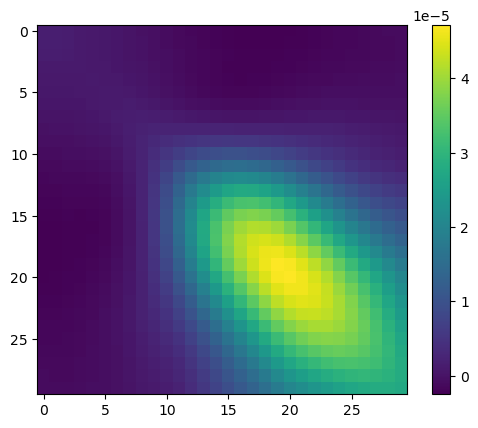

In [62]:
C = covariance_mat(mean_obs,all_obs)
C_diag = np.diag(np.diag(C))
plt.imshow(C)
plt.colorbar()

In [63]:
num_bines = mean_obs.shape[0]
njack = realizaciones
factor_h = 1 - (num_bines+1)/(njack-1)

In [53]:
V = 1440**3
shot_noise = 1/5e-04
delta_k = k[1]-k[0]
P_noise = shot_noise
P_tot = P_obs + P_noise

# Número de modos independientes (N_k)
N_k = V * (k**2) * delta_k / (2 * np.pi**2)

# Matriz de covarianza diagonal
covariance_diag = 2 * (P_tot**2) / N_k
covariance_matrix = np.diag(covariance_diag)
C_inv_pk = np.linalg.inv(covariance_matrix)

In [54]:
F_obs = mean_obs
F0 = mean_0
F1 = mean_1
F2 = mean_2
F3 = mean_3
F4 = mean_4


# Inverso de la matriz de covarianza
#C_inv = np.linalg.inv(C)
C_inv = factor_h*np.linalg.inv(C)

ndens = 5e-04
# Configuración de MCMC
ndim = 5  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 5000  # Número de pasos

# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F0, F1, F2,F3, F4, C_inv, P_obs, P00, P01, P02, P03, P04,
                                                                    P11, P12, P13, P14, P22, P23, P24, P33, P34, P44, ndens, C_inv_pk))
_ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

# Análisis de resultados
samples = sampler.get_chain(discard=500, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b3_samples, b4_samples, A_samples = samples[:, 0], samples[:, 1], samples[:,2], samples[:,3], samples[:,4]

100%|██████████████████████████████████████| 5000/5000 [00:35<00:00, 141.91it/s]


In [55]:
dist = np.linspace(0,3,f0_file.shape[1]-1)

b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b3_mean, b3_std = np.mean(b3_samples), np.std(b3_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)
A_mean, A_std = np.mean(A_samples), np.std(A_samples)

Text(0, 0.5, '$ \\delta_g(r) $')

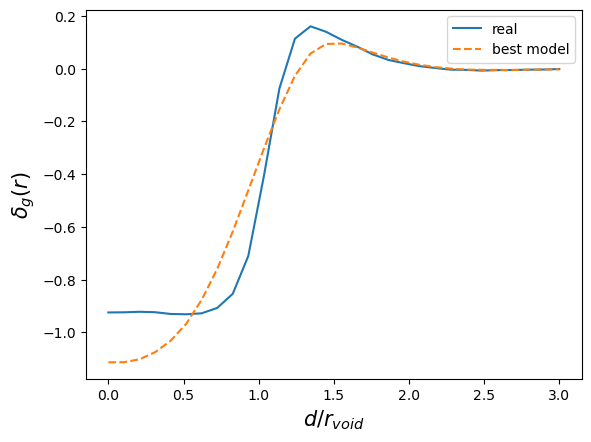

In [56]:
plt.plot(dist, F_obs, label='real')
plt.plot(dist, F0 + b1_mean*F1 + b2_mean*F2 + b3_mean*F3 + b4_mean*F4 - 1, ls='dashed', label='best model')

#plt.plot(F1,label='F1')
#plt.plot(F2,label='F2')
plt.legend()
#plt.ylim(-1.4,0.2)
plt.xlabel('$ d/r_{void}$',size=15)
plt.ylabel('$ \\delta_g(r) $',size=15)

Text(0.5, 0, '$ k$')

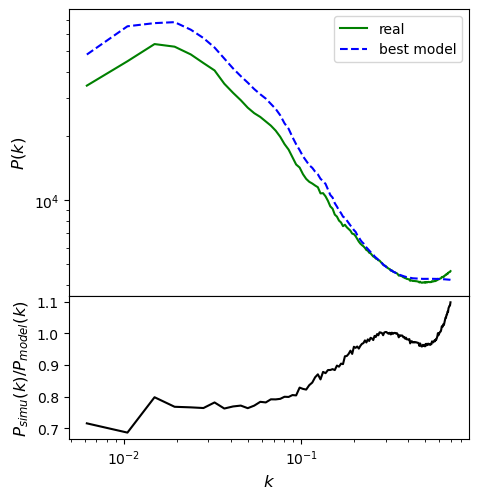

In [57]:
b0 = 1
b1 = b1_mean
b2 = b2_mean
b3 = b3_mean
b4 = b4_mean
A  = A_mean
model = (b0*b0*P00 + b0*b1*P01 + b0*b2*P02 + b0*b3*P03 + b0*b4*P04+
           b1*b0*P01 + b1*b1*P11 + b1*b2*P12 + b1*b3*P13 + b1*b4*P14 +
           b2*b0*P02 + b2*b1*P12 + b2*b2*P22 + b2*b3*P23 + b2*b4*P24 +
           b3*b0*P03 + b3*b1*P13 + b3*b2*P23 + b3*b3*P33 + b3*b4*P34 +
           b4*b0*P04 + b4*b1*P14 + b4*b2*P24 + b4*b3*P34 + b4*b4*P44) + A/ndens

fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(5,5),sharey='row'
                       ,gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=(0.00),wspace=(.28),bottom=0.12, top=0.98, left=0.17, right=0.97)


ax[0].plot(k, P_obs, label='real', color='green')
ax[0].plot(k, model, ls='dashed', label='best model', color='blue')
ax[0].semilogy()
ax[0].semilogx()
#ax[0].plot(dist, F_model_j, ls='dotted', label='jens model', color='black')
ax[0].legend()
#plt.ylim(-1.4,0.2)

ax[0].set_ylabel('$ P(k) $',size=12)

ax[1].plot(k, P_obs/model, color='black')
ax[1].set_ylabel('$ P_{simu}(k)/P_{model}(k) $',size=12)
#ax[1].set_ylabel('$\\frac{\\delta_m-\\delta_{obs}}{\\sigma}$',size=12)
ax[1].semilogx()
ax[1].set_xlabel('$ k$',size=12)

BACCO: 1.2563635822059014 -1.7434089683363208 11.834643129227596 1.1357311765711338 1.9239410348996042


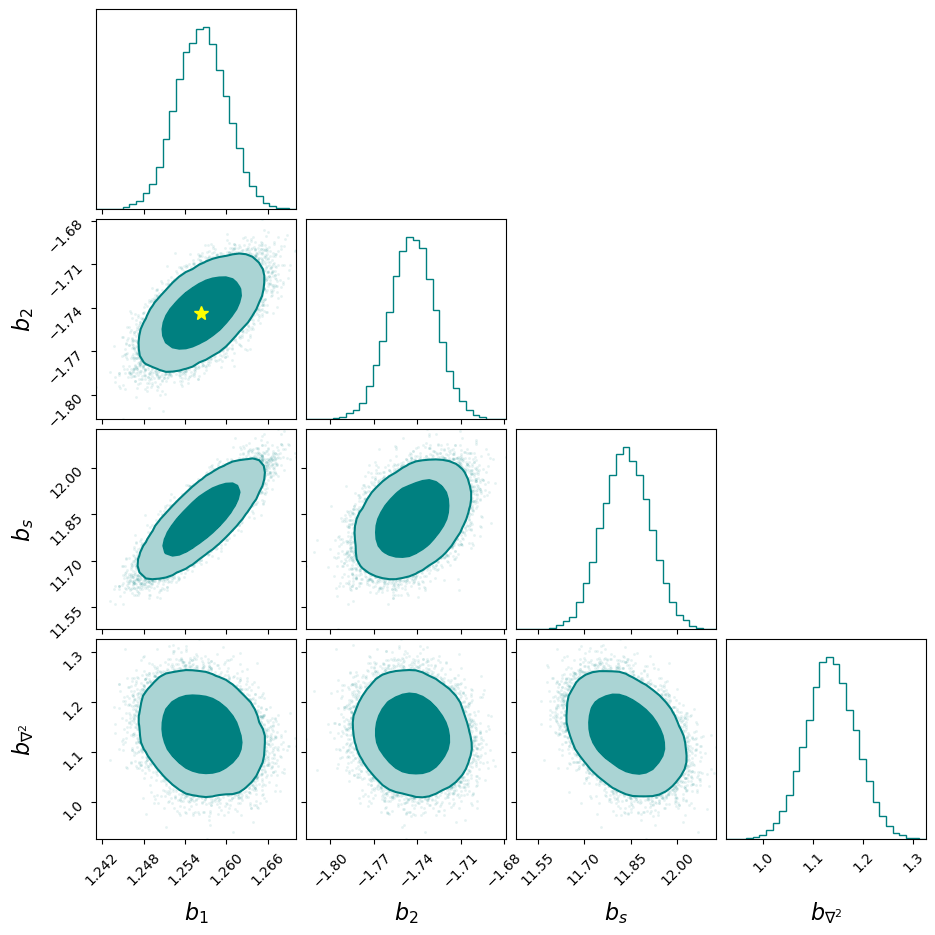

In [58]:
import corner
import random


#seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)
# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples, b2_samples, b3_samples ,b4_samples]).T,
                       labels=["$ b_1 $", "$b_2$", "$b_s$","$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
axes[4].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
axes[8].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b2, b4)
axes[12].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)

print('BACCO:',b1_mean, b2_mean, b3_mean, b4_mean, A)